In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
#import pytz
import scipy
import requests
import warnings
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

# Read in Excel Data

In [2]:
excel_path = '/'.join(['.','Data',
                      'NBA Stats_2021-2023_01292024.xlsx'])

print('Reading in games...')
games = pd.read_excel(excel_path,
                     sheet_name = 'Games',
                     header = 0,
                     index_col = 'game_id',
                     parse_dates = ['game_date'],
                     engine='openpyxl')

print('Reading in players...')
players = pd.read_excel(excel_path,
                     sheet_name = 'Players',
                     header = 0,
                       index_col = 'player_id',
                       engine='openpyxl')

print('Reading in teams...')
teams = pd.read_excel(excel_path,
                     sheet_name = 'Teams',
                     header = 0,
                     index_col = 'team_id',
                     engine='openpyxl')

print('Reading in stats...')
stats = pd.read_excel(excel_path,
                     sheet_name = 'Stats',
                     header = 0,
                     engine='openpyxl')

Reading in games...
Reading in players...
Reading in teams...
Reading in stats...


In [3]:
games.head()

,game_date,game_season,game_status,game_period,game_time,game_home_team_id,game_home_team_score,game_visitor_team_id,game_visitor_team_score,game_preseason,game_postseason
game_id,,,,,,,,,,,
473410,2021-10-19,2021,Final,4,NaN,17,127,3,104,N,False
473409,2021-10-19,2021,Final,4,NaN,14,114,10,121,N,False
473413,2021-10-20,2021,Final,4,NaN,28,83,30,98,N,False
473415,2021-10-20,2021,Final,4,NaN,15,132,6,121,N,False
473414,2021-10-20,2021,Final,6,NaN,20,138,2,134,N,False


In [4]:
players.head()

,player_team_id,player_position,player_full_name,player_first_name,player_last_name,player_height_feet,player_height_inches,player_weight_pounds
player_id,,,,,,,,
17896049,3,G,David Duke Jr.,David,Duke Jr.,NaN,NaN,NaN
17553995,14,G,Austin Reaves,Austin,Reaves,NaN,NaN,NaN
666543,14,F,Sekou Doumbouya,Sekou,Doumbouya,NaN,NaN,NaN
59,14,G,Avery Bradley,Avery,Bradley,6.0,2.0,180.0
220,14,C,Dwight Howard,Dwight,Howard,6.0,11.0,265.0


In [5]:
stats.head()

,id,game_id,player_id,team_id,opponent_team_id,min,fga,fgm,fg_pct,fta,ftm,ft_pct,fg3a,fg3m,fg3_pct,oreb,dreb,reb,pts,ast,stl,blk,pf,turnover
0,7315088,473410,17896049,3,17,0:00,0,0,0.000,0,0,0.00,0,0,0.000,0,0,0,0,0,0,0,0,0
1,7315614,473409,17553995,14,10,0:00,0,0,0.000,0,0,0.00,0,0,0.000,0,0,0,0,0,0,0,0,0
2,7315611,473409,666543,14,10,0:00,0,0,0.000,0,0,0.00,0,0,0.000,0,0,0,0,0,0,0,0,0
3,7315610,473409,59,14,10,8,3,2,0.667,0,0,NaN,3,2,0.667,1,0,1,6,1,0,0,2,1
4,7315612,473409,220,14,10,13,2,1,0.500,4,3,0.75,0,0,NaN,0,6,6,5,0,0,0,2,2


In [6]:
# Convert 'min' to numeric and fill NaN with 0
stats['min'] = pd.to_numeric(stats['min'],
                             errors = 'coerce')\
                .fillna(0)

In [7]:
# Fantasy points (PrizePicks)
## Points = 1
## Rebound = 1.2
## Assists = 1.5
## Block = 3
## Steals = 3
## Turnover = -1
stats['fpts'] = stats['pts']\
                + (1.2 * stats['reb'])\
                + (1.5 * stats['ast'])\
                + (3 * stats['blk'])\
                + (3 * stats['stl'])\
                + (-1 * stats['turnover'])

In [8]:
# Merge date of games
stats_dates = pd.merge(stats,
                      games[['game_date']],
                      how = 'left',
                      left_on = 'game_id',
                      right_index = True)\
                .sort_values(['game_date','player_id'])

In [9]:
# Merge player positions
stats_dates_pos = pd.merge(stats_dates,
                           players[['player_position']],
                           how = 'left',
                           left_on = 'player_id',
                           right_index = True)

In [10]:
# Calculate pts per 36 min by game
#stats_dates_pos['pts_per36'] = 36 * (stats_dates_pos['pts']/stats_dates_pos['min'])

In [11]:
# Determine rolling_period on rolling metrics for entire analysis
rolling_period = 62    # Based on number of observations/games, not number of days

# rolling_period_days = '120D'    # Based on number of days, not number of observations/games

# Team Stats

In [12]:
stats_dates_pos.head()

,id,game_id,player_id,team_id,opponent_team_id,min,fga,fgm,fg_pct,fta,ftm,ft_pct,fg3a,fg3m,fg3_pct,oreb,dreb,reb,pts,ast,stl,blk,pf,turnover,fpts,game_date,player_position
26,7315084,473410,6,3,17,16.0,2,0,0.000,4,1,0.250,0,0,NaN,0,3,3,1,1,0,1,2,1,8.1,2021-10-19,F
35,7315097,473410,8,17,3,28.0,10,3,0.300,1,1,1.000,10,3,0.30,0,4,4,10,6,2,0,0,0,29.8,2021-10-19,G
48,7315095,473410,15,17,3,31.0,25,12,0.480,9,7,0.778,4,1,0.25,5,9,14,32,7,1,2,4,4,64.3,2021-10-19,F
6,7315609,473409,17,14,10,26.0,9,3,0.333,2,1,0.500,4,2,0.50,0,4,4,9,2,0,0,2,1,15.8,2021-10-19,F
9,7315607,473409,36,14,10,31.0,9,3,0.333,0,0,NaN,8,2,0.25,0,2,2,8,0,0,1,4,1,12.4,2021-10-19,G


In [13]:
def team_pts_rolling_mean(group):
    group_indexed = group.set_index('game_date')
    
    rolling_group = group_indexed\
                    [['pts']]\
                    .rolling(rolling_period,
                             min_periods = 1)\
                    .mean()\
                    .rename(columns = {'pts':'ppg'})
    
    return rolling_group

## Defensive Efficiency by Position

In [14]:
team_def_eff_pos = stats_dates_pos\
                        .groupby(['opponent_team_id','game_date','player_position'])\
                        [['pts']]\
                        .sum()\
                        .reset_index()

In [15]:
team_stats_rolling_def_eff = team_def_eff_pos.groupby(['opponent_team_id','player_position'])\
                            .apply(team_pts_rolling_mean)\
                            .reset_index()\
                            .rename(columns = {'opponent_team_id':'team_id',
                                              'ppg':'def_ppg'})

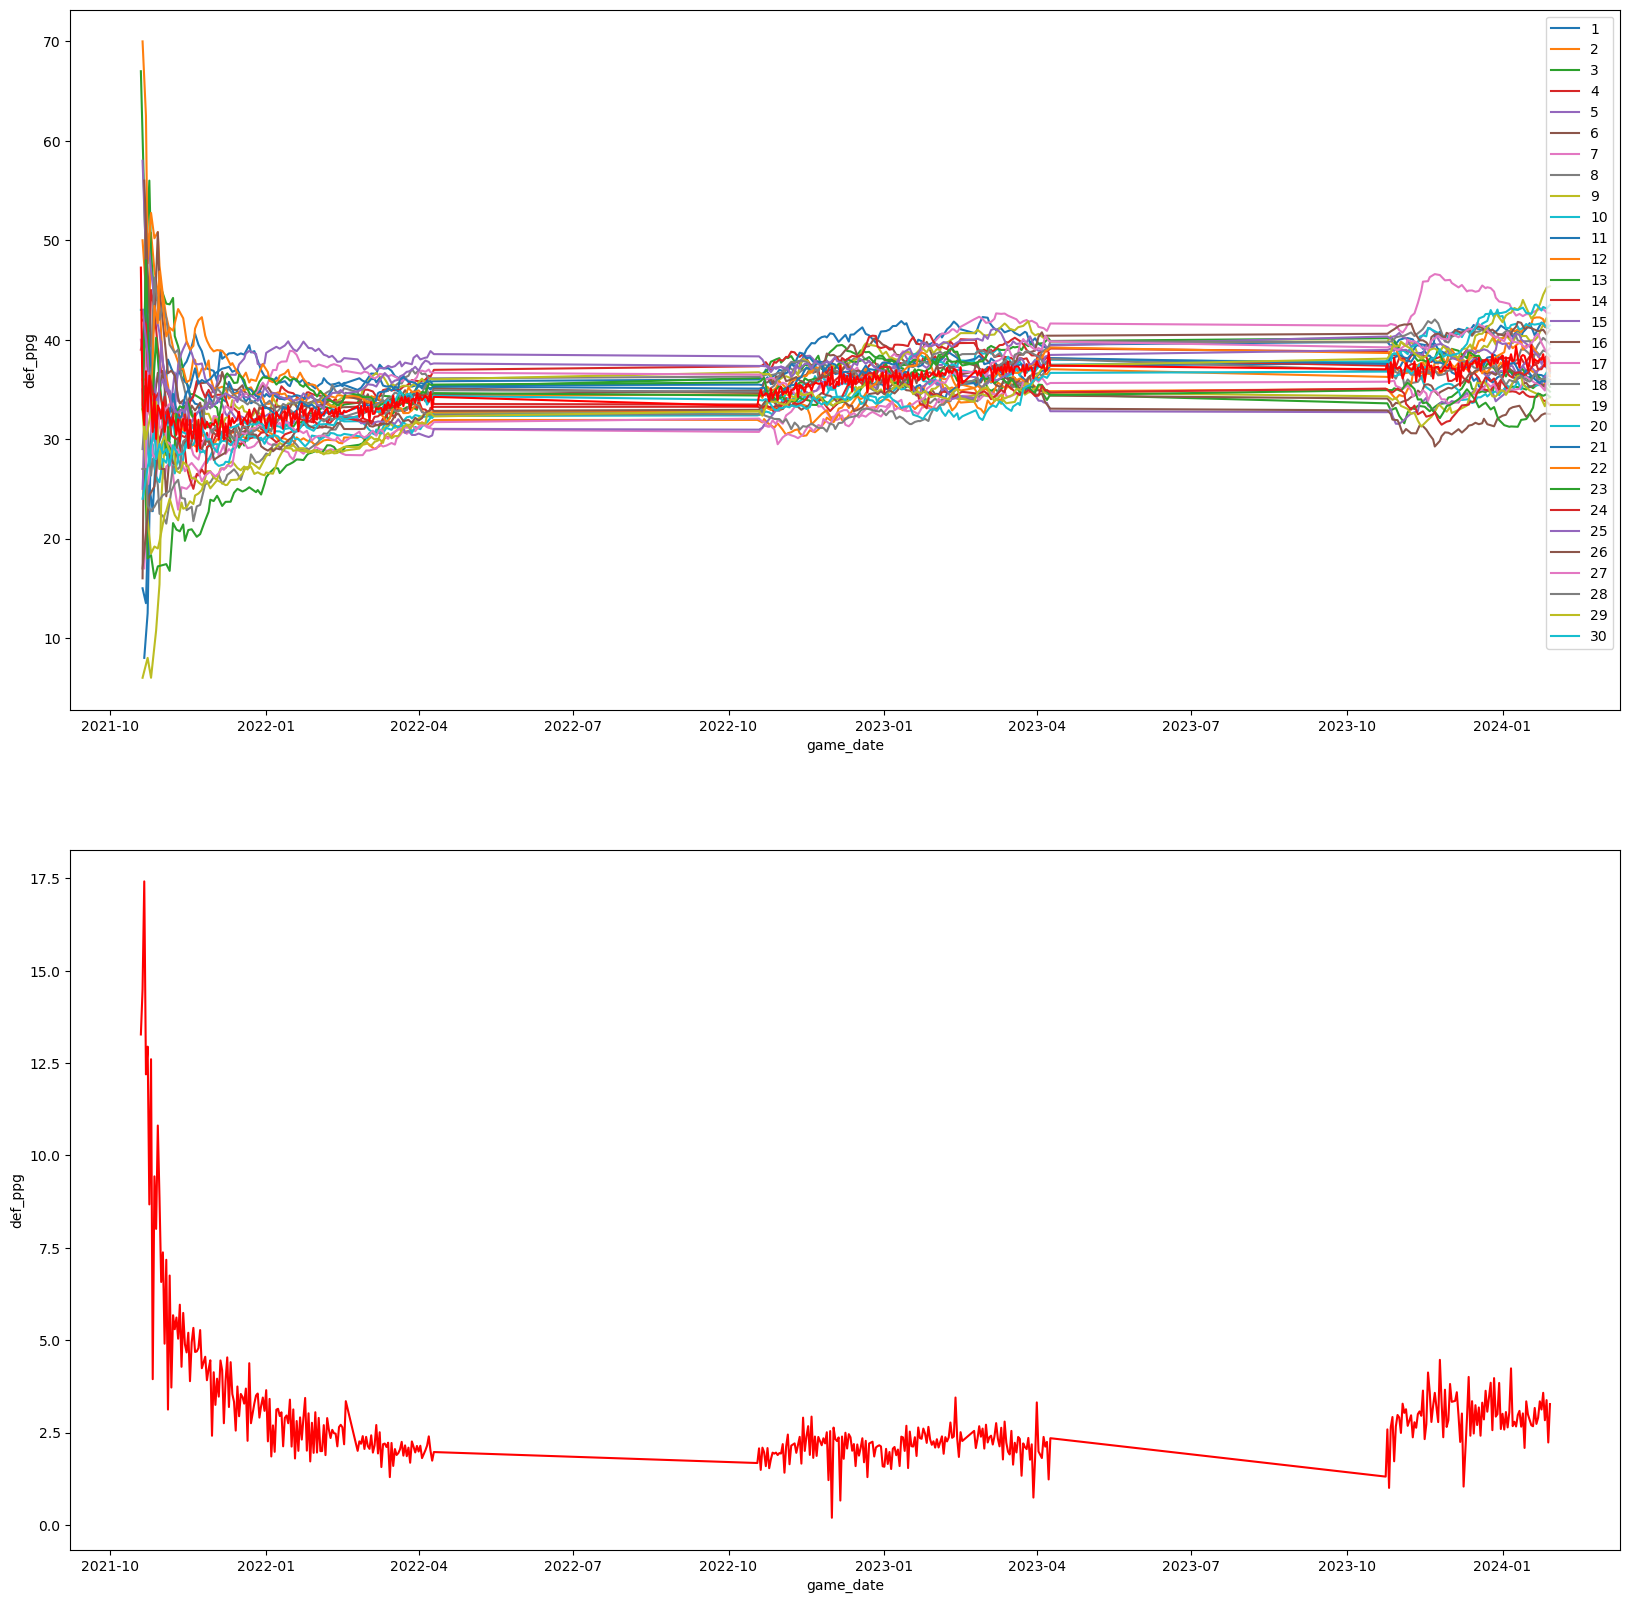

In [109]:
player_position = 'F'

fig = plt.figure(figsize = (20,20))
ax = plt.subplot(2,1,1)
sns.lineplot(data = team_stats_rolling_def_eff[team_stats_rolling_def_eff['player_position'] == player_position],
                  x = 'game_date',
                  y = 'def_ppg',
                  hue = 'team_id',
                  palette = sns.color_palette(),
                  ci = None)
ax2 = sns.lineplot(data = team_stats_rolling_def_eff[team_stats_rolling_def_eff['player_position'] == player_position]\
                           .groupby('game_date')\
                           [['def_ppg']]\
                           .mean()\
                           .reset_index(),
                  x = 'game_date',
                  y = 'def_ppg',
                   color = 'red',
                  dashes = True)
plt.legend(loc = 'upper right')

ax = plt.subplot(2,1,2)
ax2 = sns.lineplot(data = team_stats_rolling_def_eff[team_stats_rolling_def_eff['player_position'] == player_position]\
                           .groupby('game_date')\
                           [['def_ppg']]\
                           .std()\
                           .reset_index(),
                  x = 'game_date',
                  y = 'def_ppg',
                   color = 'red',
                  dashes = True)

fig.show()

### Ranking Team Defensive Capability by Position

In [81]:
team_def_eff_resampled = team_stats_rolling_def_eff.set_index('game_date')\
                            .groupby(['team_id',
                                      'player_position'])\
                            .resample('1D')\
                            [['def_ppg']]\
                            .ffill()\
                            .reset_index()

In [90]:
team_def_eff_ranked = team_def_eff_resampled.groupby(['game_date','player_position'])\
                        .apply(lambda x: x.set_index('team_id')
                                           [['def_ppg']]\
                                           .rank(method = 'min',
                                                 na_option = 'bottom')\
                              )\
                        .reset_index()

In [100]:
team_def_eff_pos_mean = team_def_eff_ranked.groupby(['team_id','player_position'])[['def_ppg']].mean().reset_index()
team_def_eff_pos_mean_pivoted = pd.pivot_table(team_def_eff_pos_mean,
                                               index = 'player_position',
                                               columns = 'team_id')

In [104]:
team_def_eff_pos_mean_pivoted

def_ppg                                              \
team_id                 1          2          3          4          5    
player_position                                                          
C                15.679518   4.683894  14.483794  24.082933  10.315283   
F                25.591566   7.706731  14.250900  22.155048  17.665463   
F-C              17.710843  20.313559  13.513253  25.437500  20.271961   
G                11.348193   6.694712  18.174070  12.153846  12.913357   
G-F              20.869880  18.354217  19.543478  15.735577   7.980746   
UNK              22.033251  16.067797  19.401709  21.260816  23.356098   

                                                                        \
team_id                 6          7          8          9          10   
player_position                                                          
C                13.585337  18.962696  17.094952  20.506619   7.063779   
F                12.709135  16.187726  16.028846  23.604091  11.316486   
F-C               7.138221   4.942029  12.060241  23.704600  13.613718   
G                 3.879808  11.998797  15.296875  15.883273  15.234657   
G-F              15.963942   4.361111  12.417874  10.178099  25.127427   
UNK              12.632282  10.362864   5.431447  18.321429   2.607407   

                                                                        \
team_id                 11         12         13         14         15   
player_position                                                          
C                19.896635  22.040915  13.717732  11.240964  18.078125   
F                18.102163  14.835138  17.935018  15.803121  15.318510   
F-C               9.507212  21.665463  26.075995  18.907229   5.067389   
G                23.574519  26.240674  10.056558  23.979592  12.423077   
G-F              12.901205  13.711353  13.683514  21.349340  13.725632   
UNK              24.596814   6.484223   2.300725   6.459687  18.361416   

                                                                        \
team_id                 16         17         18         19         20   
player_position                                                          
C                 8.419976  12.510229  12.562123  16.512019   4.558894   
F                12.785800  15.518607  22.080529   6.256010  12.841346   
F-C               2.709288  24.082833  18.350962  14.754808  20.831325   
G                 9.346570  14.439376  20.692308  15.518029  11.450721   
G-F               7.385732  11.356543  11.424608  27.839566   8.849398   
UNK              26.797834  18.206107  25.899363  14.271499  14.242054   

                                                                        \
team_id                 21         22         23         24         25   
player_position                                                          
C                14.247596  13.753606  17.213942  11.025240  22.806490   
F                18.957933  16.572115  13.777644   9.882212  22.390625   
F-C               6.600962  24.732769  13.577108   9.758413  11.300481   
G                20.686298  13.358173   6.036058  16.306490  18.084135   
G-F              20.437727  12.328125  22.201923   8.877404  20.032648   
UNK              10.101110  15.138686  14.006305  23.378606  23.971570   

                                                                        
team_id                 26         27         28         29         30  
player_position                                                         
C                26.377404  28.716867  10.119421  11.237981  21.900000  
F                17.056490  13.270433  11.197353   9.519231  12.111779  
F-C              10.637349  11.781401  23.019254  10.213942  21.325301  
G                22.487981  27.033654   8.007220  21.411058  19.685096  
G-F              24.802885  19.348613  13.644150  22.048077   7.360577  
UNK              11.334951  18.294046   3.059202  19.668712   9.160200

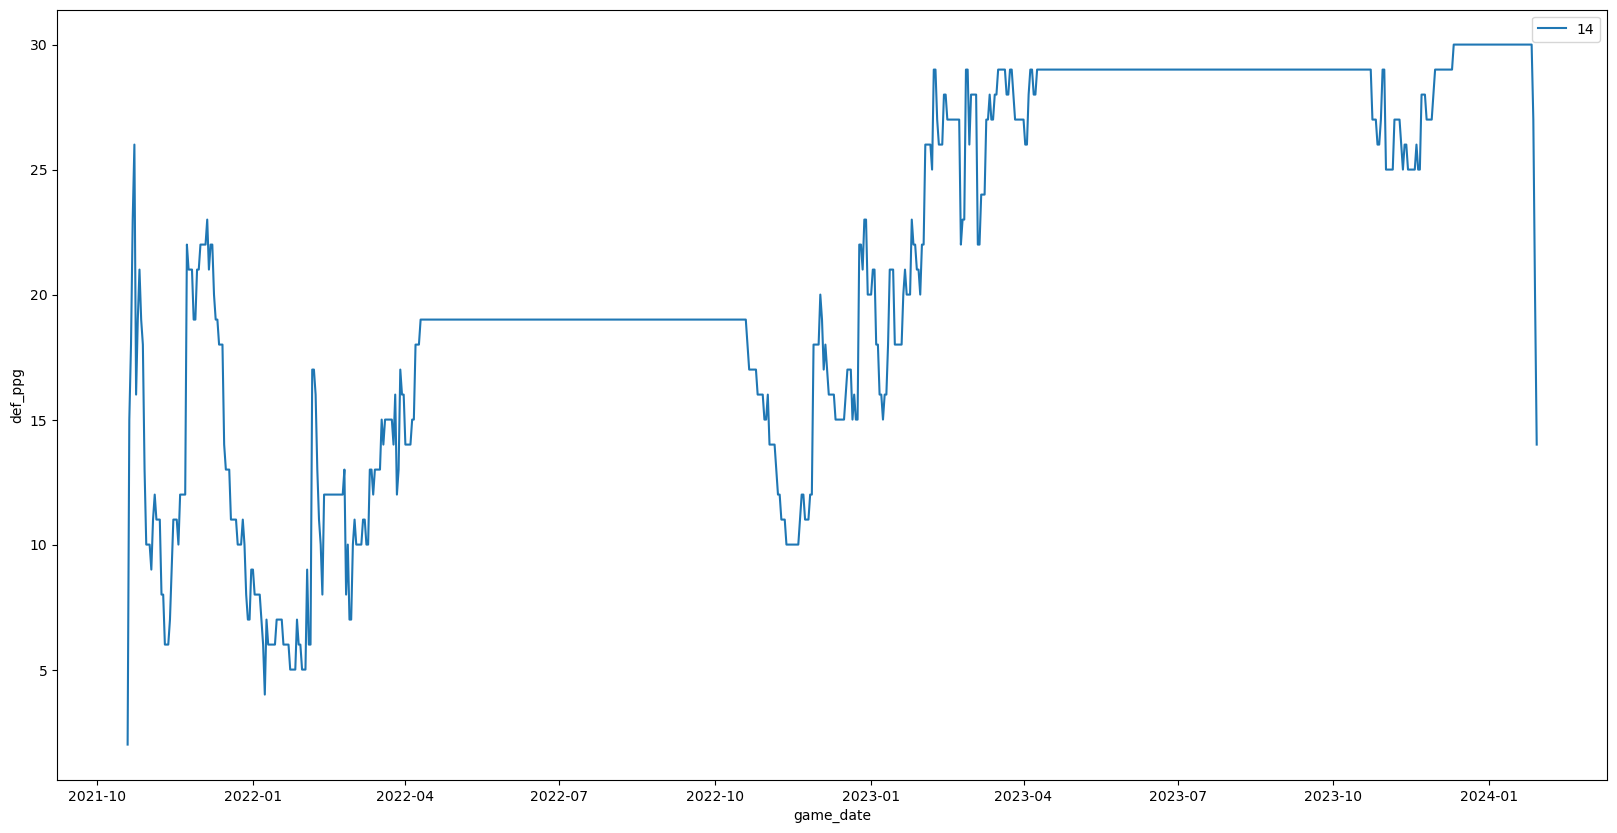

In [96]:
player_position = 'G-F'

fig = plt.figure(figsize = (20,10))
ax = sns.lineplot(data = team_def_eff_ranked[(team_def_eff_ranked['player_position'] == player_position)
                                              & (team_def_eff_ranked['team_id'] == 14)],
                  x = 'game_date',
                  y = 'def_ppg',
                  hue = 'team_id',
                  palette = sns.color_palette(),
                  ci = None)
plt.legend(loc = 'upper right')
fig.show()

## Offensive Efficiency by Position

In [16]:
team_off_eff_pos = stats_dates_pos\
                        .groupby(['team_id','game_date','player_position'])\
                        [['pts']]\
                        .sum()\
                        .reset_index()

In [17]:
team_stats_rolling_off_eff = team_off_eff_pos.groupby(['team_id','player_position'])\
                            .apply(team_pts_rolling_mean)\
                            .reset_index()\
                            .rename(columns = {'ppg':'off_ppg'})

## Merge Team Defensive and Offensive Efficiency by Position

In [18]:
team_eff_pos = pd.merge(team_stats_rolling_off_eff,
                        team_stats_rolling_def_eff,
                        how = 'outer',
                        left_on = ['team_id','game_date','player_position'],
                        right_on = ['team_id','game_date','player_position'])

## League Team Averages

In [19]:
def league_team_pts_stats(group):
    '''
    Grouping function to get standard deviation of pts_per36 for each player on a given date
    Need to account for offseason/days where there are no games
    '''
    # Sort by date and player prior to resampling
    group_sorted = group.sort_values(['game_date','team_id'])\
                        .set_index(['game_date'])
    
    # Resample data to daily by each player
    ## Forward fill blank values
    group_resampled = group_sorted.groupby('team_id')\
                        .resample('1D')\
                        [['pts_off','pts_def']]\
                        .last()
    
    # Were games played on date
    ## Due to resample, dates in the off season were added
    ## Need to remove; will cause calculations over at the beginning of each season
    date_no_minutes = group_resampled.groupby(level = 1)\
                        .apply(lambda x: x.isna()\
                                           .all()
                              )
    
    # Drop dates with no games
    ## Includes in-season breaks
    date_no_games = date_no_minutes[(date_no_minutes['pts_off'] == True)
                                   & (date_no_minutes['pts_def'] == True)].index
    
    group_resampled.drop(index = date_no_games,
                        level = 1,
                        inplace = True)
    
    # Forward fill values by player
    final_group_resampled = group_resampled.groupby(level = [0])[['pts_off','pts_def']].ffill()
    
    # Calculate the standard deviation of pts_per36 for all players by date
    final_rolling_stats = final_group_resampled.groupby(level = 1).agg(['mean',
                                                                        'std'])
    
    return final_rolling_stats

In [20]:
# Calculate teams offensive pts production by position per game
team_pos_off_pts_total = stats_dates_pos.groupby(['game_date',
                                                  'player_position',
                                                  'team_id'])\
                            [['pts']]\
                            .sum()\
                            .reset_index()\
                            .rename(columns = {'pts':'pts_off'})

# Calculate teams defensive pts production by position per game
team_pos_def_pts_total = stats_dates_pos.groupby(['game_date',
                                                  'player_position',
                                                  'opponent_team_id'])\
                            [['pts']]\
                            .sum()\
                            .reset_index()\
                            .rename(columns = {'opponent_team_id':'team_id',
                                               'pts':'pts_def'})

# Merge teams offensive and defensive production by position
team_pos_eff_total = pd.merge(team_pos_off_pts_total,
                               team_pos_def_pts_total,
                               how = 'outer',
                               left_on = ['game_date','team_id','player_position'],
                               right_on = ['game_date','team_id','player_position'])

In [21]:
team_pos_rolling_eff = team_pos_eff_total\
                        .groupby('player_position')\
                        .apply(league_team_pts_stats)

In [22]:
team_pos_rolling_eff.columns = ['_'.join(i) for i in team_pos_rolling_eff.columns]

In [23]:
team_pos_rolling_eff.reset_index(inplace = True)

# Player Stats

## Individual Player Efficiency

In [24]:
def player_pts_rolling_sum(group):
    group_indexed = group.sort_values('game_date')\
                    .set_index('game_date')
    
    rolling_group = group_indexed\
                        [['min','pts']]\
                       .rolling(rolling_period,
                                min_periods = 1)\
                       .sum()
    
    rolling_min_mean = group_indexed\
                        [['min']]\
                        .rolling(rolling_period,
                                 min_periods = 1)\
                        .mean()
    
    rolling_merged = pd.merge(rolling_min_mean,
                              rolling_group,
                              how = 'outer',
                              left_index = True,
                              right_index = True,
                             suffixes = ['_mean','_cumsum'])
    
    return rolling_merged

In [25]:
player_stats_rolling_eff = stats_dates.groupby('player_id')\
                            .apply(player_pts_rolling_sum)

# player_stats_rolling_eff = stats_dates.set_index('game_date')\
#                             .groupby(stats_dates['player_id'])\
#                             [['min','pts']]\
#                             .rolling(rolling_period,
#                                     min_periods = 1)\
#                             .sum()\
#                             .shift(1)\
#                             .dropna(how = 'all')

In [26]:
player_stats_rolling_eff

min_mean  min_cumsum   pts
player_id game_date                             
3         2021-10-20     32.00        32.0   8.0
          2021-10-23     29.50        59.0  25.0
          2021-10-24     31.00        93.0  39.0
          2021-10-27     27.75       111.0  43.0
          2021-10-28     26.40       132.0  55.0
...                        ...         ...   ...
59421201  2023-12-13      0.00         0.0   0.0
          2023-12-15      0.00         0.0   0.0
          2023-12-16      0.00         0.0   0.0
          2023-12-18      0.00         0.0   0.0
          2023-12-20      0.00         0.0   0.0

[96937 rows x 3 columns]

In [27]:
stat_categories = player_stats_rolling_eff.columns.drop(['min_mean','min_cumsum'])

In [28]:
for cat in stat_categories:
    player_stats_rolling_eff[cat+'_per36'] = player_stats_rolling_eff[cat] * (36/player_stats_rolling_eff['min_cumsum'])

In [29]:
actual_eff_merged = pd.merge(stats_dates_pos[['game_date','player_id','player_position',
                                              'min','pts']],
                             player_stats_rolling_eff.reset_index()\
                                 [['game_date','player_id','pts_per36','min_mean']],
                             how = 'left',
                             left_on = ['player_id','game_date'],
                             right_on = ['player_id','game_date'])#\
                    #.sort_values(['player_id','game_date'])

In [30]:
per36_stat_cols = [i for i in actual_eff_merged.columns if ('_per36' in i)]

## League Position Average

In [31]:
def league_player_pts_stats(group):
    '''
    Grouping function to get standard deviation of pts_per36 for each player on a given date
    Need to account for offseason/days where there are no games
    '''
    # Sort by date and player prior to resampling
    group_sorted = group.sort_values(['game_date','player_id'])\
                        .set_index(['game_date'])
    
    # Resample data to daily by each player
    ## Forward fill blank values
    group_resampled = group_sorted.groupby(['player_id',
                                           ])\
                        .resample('1D')\
                        [['pts_per36']]\
                        .last()
    
    # Were games played on date
    ## Due to resample, dates in the off season were added
    ## Need to remove; will cause calculations over at the beginning of each season
    date_no_minutes = group_resampled.groupby(level = 1)\
                        .apply(lambda x: x.isna()\
                                           .all()
                              )
    
    # Drop dates with no games
    ## Includes in-season breaks
    date_no_games = date_no_minutes[(date_no_minutes['pts_per36'] == True)].index
    
    group_resampled.drop(index = date_no_games,
                        level = 1,
                        inplace = True)
    
    # Forward fill values by player
    final_group_resampled = group_resampled.groupby(level = [0])[['pts_per36']].ffill()
    
    # Calculate the standard deviation of pts_per36 for all players by date
    final_rolling_stats = final_group_resampled.groupby(level = [1]).agg(['mean',
                                                                          'std'])
    final_rolling_stats.columns = ['_'.join(i) for i in final_rolling_stats.columns]

    final_rolling_stats_list = final_group_resampled.groupby(level = [1])['pts_per36'].apply(list).reset_index(name = 'list').set_index('game_date')

    final_merged = pd.merge(final_rolling_stats,
                            final_rolling_stats_list,
                            how = 'inner',
                            left_index = True,
                            right_on = 'game_date')
    
    return final_merged

In [32]:
league_player_rolling_stats = actual_eff_merged.groupby('player_position',
                                                       dropna = False)\
                                .apply(league_player_pts_stats)

In [33]:
league_player_rolling_stats

pts_per36_mean  pts_per36_std  \
player_position game_date                                   
C               2021-10-19        9.890110       4.167951   
                2021-10-20       15.648623       7.949697   
                2021-10-21       17.388892       9.092027   
                2021-10-22       17.848332       8.883323   
                2021-10-23       17.205380       8.062361   
...                                    ...            ...   
UNK             2024-01-25       12.513460       2.383191   
                2024-01-26       12.495996       2.303895   
                2024-01-27       12.411966       2.334460   
                2024-01-28       12.466078       2.634246   
                2024-01-29       11.466238       1.761111   

                                                                         list  
player_position game_date                                                      
C               2021-10-19  [13.846153846153847, 5.538461538461538, 10.285...  
                2021-10-20  [9.0, 31.03448275862069, 16.363636363636363, 2...  
                2021-10-21  [9.0, 31.03448275862069, 16.363636363636363, 2...  
                2021-10-22  [9.0, 23.142857142857146, 12.545454545454545, ...  
                2021-10-23  [15.254237288135593, 19.01123595505618, 12.130...  
...                                                                       ...  
UNK             2024-01-25  [10.437869822485208, 12.191693290734824, 12.25...  
                2024-01-26  [10.437869822485208, 12.191693290734824, 12.25...  
                2024-01-27  [10.255813953488373, 11.773584905660378, 12.25...  
                2024-01-28  [10.255813953488373, 11.773584905660378, 16.37...  
                2024-01-29  [10.255813953488373, 11.618441971383149, 10.09...  

[2514 rows x 3 columns]

In [34]:
#league_player_rolling_stats.columns = ['_'.join(i) for i in league_player_rolling_stats.columns]

In [35]:
league_player_rolling_stats.reset_index(inplace = True)

# Shift Data
Need to shift team efficiency, player efficiency, and league rolling data down a row so they can be used as dependent variables on the actual predictor variable

In [36]:
team_eff_pos_shifted = team_eff_pos.groupby(['team_id','player_position'])\
                        .apply(lambda x: x.sort_values('game_date')\
                                           .set_index('game_date')\
                                           [['off_ppg','def_ppg']]\
                                           .shift(1))\
                        .reset_index()

In [37]:
team_pos_rolling_eff_shifted = team_pos_rolling_eff.groupby('player_position')\
                                .apply(lambda x: x.sort_values('game_date')\
                                                   .set_index('game_date')\
                                                   [['pts_off_mean','pts_off_std',
                                                     'pts_def_mean','pts_def_std']]\
                                                   .shift(1))\
                                .reset_index()

In [38]:
actual_eff_merged_shifted = actual_eff_merged.groupby(['player_id','player_position'])\
                                .apply(lambda x: x.sort_values('game_date')\
                                                   .set_index('game_date')\
                                                   [['pts_per36','min_mean']]\
                                                   .shift(1))\
                                .reset_index()

In [39]:
league_player_rolling_stats_shifted = league_player_rolling_stats.groupby('player_position')\
                                        .apply(lambda x: x.sort_values('game_date')\
                                                           .set_index('game_date')\
                                                           [['pts_per36_mean','pts_per36_std','list']]\
                                                           .shift(1))\
                                        .reset_index()

# Merge Data

## Merge Team Stats

In [40]:
rolling_stats_teams = pd.merge(team_eff_pos_shifted.rename(columns = {'off_ppg':'team_off_ppg',
                                                                      'def_ppg':'team_def_ppg'}),
                               team_pos_rolling_eff_shifted.rename(columns = {'pts_off_mean':'league_ppg_off_mean',
                                                                              'pts_off_std':'league_ppg_off_std',
                                                                              'pts_def_mean':'league_ppg_def_mean',
                                                                              'pts_def_std':'league_ppg_def_std'}),
                               how = 'outer',
                               left_on = ['player_position','game_date'],
                               right_on = ['player_position','game_date'])\
                        .sort_values(['game_date','player_position','team_id'])

## Merge Player Stats

In [41]:
rolling_stats_players = pd.merge(actual_eff_merged_shifted.rename(columns = {'pts_per36':'player_pts_per36',
                                                                            'min_mean':'player_avg_min'}),
                                 league_player_rolling_stats_shifted.rename(columns = {'pts_per36_mean':'league_player_pts_per36_mean',
                                                                                       'pts_per36_std':'league_player_pts_per36_std'}),
                                 how = 'outer',
                                 left_on = ['player_position','game_date'],
                                 right_on = ['player_position','game_date'])\
                        .sort_values(['game_date','player_position','player_id'])

## Merge Player and Team Stats to Relevant Stats

In [42]:
# Table of relevant fields from original data
rel_stats = stats_dates_pos[['game_date',
                             'player_id','player_position',
                             'team_id','opponent_team_id',
                             'min','pts']]

In [43]:
rel_rolling_players = pd.merge(rel_stats,
                               rolling_stats_players,
                               how = 'outer',
                               left_on = ['game_date','player_id','player_position'],
                               right_on = ['game_date','player_id','player_position'])
                         

In [44]:
rel_rolling_team_off = pd.merge(rel_rolling_players,
                                rolling_stats_teams[['team_id','player_position','game_date',
                                                     'team_off_ppg','league_ppg_off_mean','league_ppg_off_std'
                                                    ]],
                                how = 'left',
                                left_on = ['game_date','team_id','player_position'],
                                right_on = ['game_date','team_id','player_position'])

In [45]:
rel_rolling_team_opp = pd.merge(rel_rolling_team_off,
                                rolling_stats_teams[['team_id','player_position','game_date',
                                                     'team_def_ppg','league_ppg_def_mean','league_ppg_def_std'
                                                    ]]\
                                    .rename(columns = {'team_def_ppg':'opponent_team_def_ppg'}),
                                how = 'left',
                                left_on = ['game_date','opponent_team_id','player_position'],
                                right_on = ['game_date','team_id','player_position'],
                               suffixes = ['','_y'])\
                        .drop('team_id_y',
                              axis = 1)

# Standardize Data

## Team Data Standardization

In [46]:
rel_rolling_team_opp['team_off_ppg_stand'] = (rel_rolling_team_opp['team_off_ppg'] - rel_rolling_team_opp['league_ppg_off_mean'])/rel_rolling_team_opp['league_ppg_off_std']

## Opponent Team Data Standardization

In [47]:
rel_rolling_team_opp['opp_def_ppg_stand'] = (rel_rolling_team_opp['opponent_team_def_ppg'] - rel_rolling_team_opp['league_ppg_def_mean'])/rel_rolling_team_opp['league_ppg_def_std']

## Player Data Standardization

In [48]:
rel_rolling_team_opp['player_pts_per36_stand'] = (rel_rolling_team_opp['player_pts_per36'] - rel_rolling_team_opp['league_player_pts_per36_mean'])/rel_rolling_team_opp['league_player_pts_per36_std']

# Plotting

## Team Data

In [49]:
rel_rolling_team_opp[(rel_rolling_team_opp['game_date'] > '2021-12-01')
                        & (rel_rolling_team_opp['player_position'] != 'UNK')]['opp_def_ppg_stand'].max()

1.3056993854290835

In [50]:
rel_rolling_team_opp[rel_rolling_team_opp['opp_def_ppg_stand'] == rel_rolling_team_opp[(rel_rolling_team_opp['game_date'] > '2021-12-01')
                        & (rel_rolling_team_opp['player_position'] != 'UNK')]['opp_def_ppg_stand'].max()]

,game_date,player_id,player_position,team_id,opponent_team_id,min,pts,player_pts_per36,player_avg_min,league_player_pts_per36_mean,league_player_pts_per36_std,list,team_off_ppg,league_ppg_off_mean,league_ppg_off_std,opponent_team_def_ppg,league_ppg_def_mean,league_ppg_def_std,team_off_ppg_stand,opp_def_ppg_stand,player_pts_per36_stand
13256,2021-12-28,11,G-F,6,19,14.0,2,12.000000,16.50,15.06036,4.254706,"[12.0, 12.360515021459229, 23.762589928057555,...",8.441176,11.0,8.896227,19.95,10.866667,6.95668,-0.28763,1.305699,-0.719288
13398,2021-12-28,3547247,G-F,6,19,31.0,6,12.280374,26.75,15.06036,4.254706,"[12.0, 12.360515021459229, 23.762589928057555,...",8.441176,11.0,8.896227,19.95,10.866667,6.95668,-0.28763,1.305699,-0.653391


In [51]:
rel_rolling_team_opp[(rel_rolling_team_opp['opponent_team_id'] == 2)
                        & (rel_rolling_team_opp['player_position'] == 'G-F')]\
    [['game_date','opp_def_ppg_stand']]\
    .drop_duplicates()

,game_date,opp_def_ppg_stand
100,2021-10-20,NaN
725,2021-10-22,3.069379
2628,2021-11-01,NaN
3081,2021-11-03,1.039028
3245,2021-11-04,0.599528
...,...,...
94219,2024-01-19,0.051093
94708,2024-01-21,0.382679
94939,2024-01-22,0.283233
95645,2024-01-25,0.058456


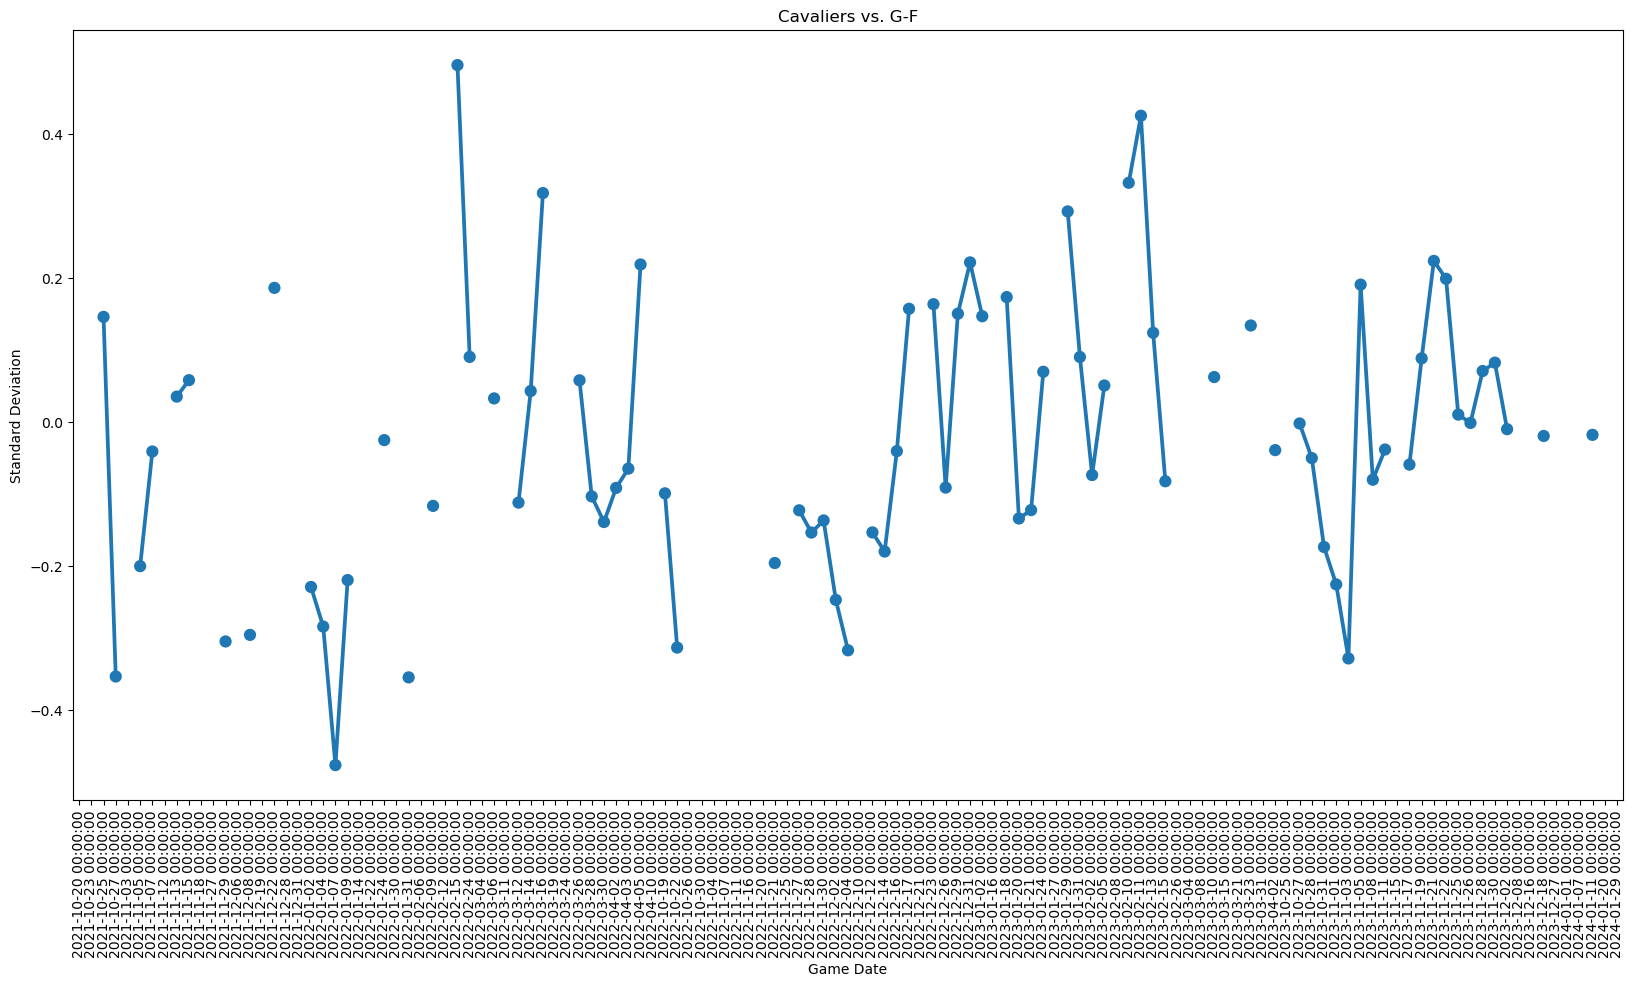

In [52]:
opponent_team_id = 6
opponent_team_name = teams[teams.index == opponent_team_id]['team_name'][opponent_team_id]
player_position = 'G-F'

fig = plt.figure(figsize = (20,10))
ax = sns.pointplot(data = rel_rolling_team_opp[(rel_rolling_team_opp['opponent_team_id'] == opponent_team_id)
                                               & (rel_rolling_team_opp['player_position'] == player_position)]\
                            [['game_date','opp_def_ppg_stand']]\
                            .drop_duplicates(),
                   x = 'game_date',
                   y = 'opp_def_ppg_stand',
                  ci = None)
ax.set_title('%s vs. %s' %(opponent_team_name, player_position))
ax.set_xlabel('Game Date')
ax.set_ylabel('Standard Deviation')

# xaxis_date_format = mdates.DateFormatter('%y-%m')
# plt.gca().xaxis.set_major_formatter(xaxis_date_format)

plt.xticks(rotation=90)
# fig.tight_layout()
fig.show()

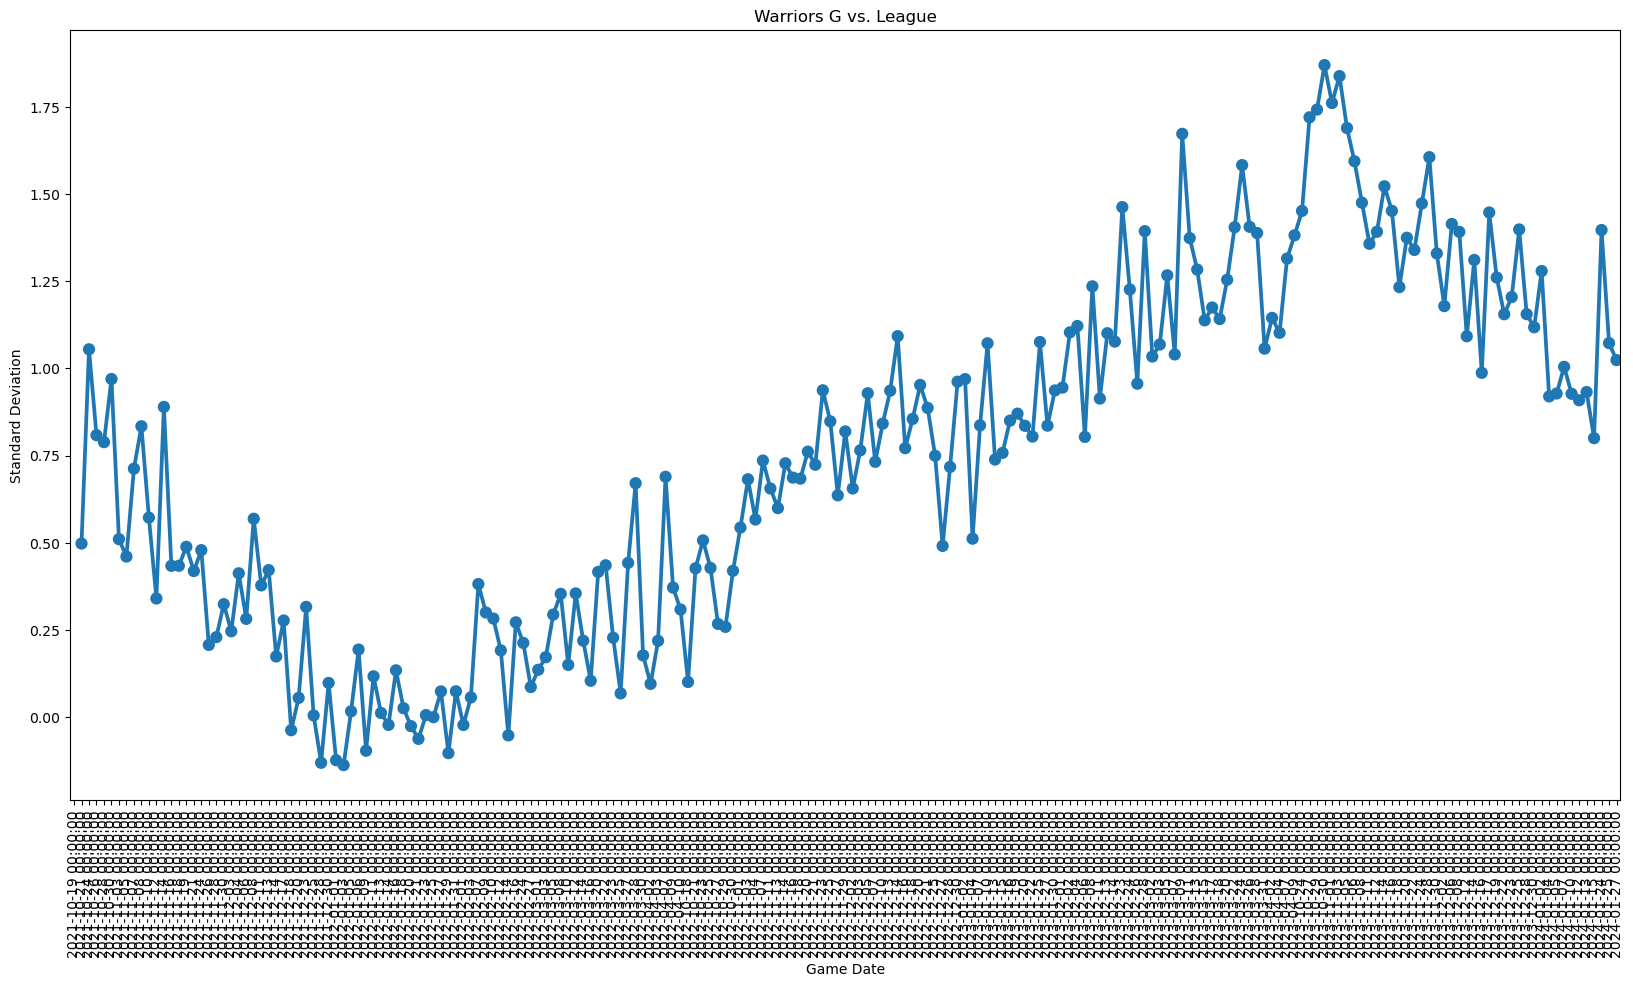

In [53]:
team_id = 10
team_name = teams[teams.index == team_id]['team_name'][team_id]
player_position = 'G'

fig = plt.figure(figsize = (20,10))
ax = sns.pointplot(data = rel_rolling_team_opp[(rel_rolling_team_opp['team_id'] == team_id)
                                               & (rel_rolling_team_opp['player_position'] == player_position)]\
                            [['game_date','team_off_ppg_stand']]\
                            .drop_duplicates(),
                   x = 'game_date',
                   y = 'team_off_ppg_stand',
                  ci = None)
ax.set_title('%s %s vs. League' %(team_name, player_position))
ax.set_xlabel('Game Date')
ax.set_ylabel('Standard Deviation')

# xaxis_date_format = mdates.DateFormatter('%y-%m')
# plt.gca().xaxis.set_major_formatter(xaxis_date_format)

plt.xticks(rotation=90)
# fig.tight_layout()
fig.show()

## Player Data

In [54]:
rel_rolling_team_opp[rel_rolling_team_opp['player_id'] == 175]

,game_date,player_id,player_position,team_id,opponent_team_id,min,pts,player_pts_per36,player_avg_min,league_player_pts_per36_mean,league_player_pts_per36_std,list,team_off_ppg,league_ppg_off_mean,league_ppg_off_std,opponent_team_def_ppg,league_ppg_def_mean,league_ppg_def_std,team_off_ppg_stand,opp_def_ppg_stand,player_pts_per36_stand
102,2021-10-20,175,G,21,29,33.0,18,NaN,NaN,17.554420,8.498880,"[12.857142857142858, 9.290322580645162, 27.0, ...",NaN,44.500000,11.090537,NaN,44.500000,11.090537,NaN,NaN,NaN
500,2021-10-22,175,G,21,11,26.0,13,19.636364,33.000000,17.520714,8.477844,"[15.157894736842104, 4.235294117647059, 13.090...",42.000000,48.366667,17.223647,74.000000,49.366667,16.959350,-0.369647,1.452493,0.249550
993,2021-10-24,175,G,21,23,39.0,29,18.915254,29.500000,17.013971,7.618298,"[14.74698795180723, 6.923076923076923, 14.2641...",42.000000,44.800000,15.831875,42.500000,46.066667,14.330901,-0.176858,-0.248879,0.249568
1409,2021-10-26,175,G,21,10,36.0,30,22.040816,32.666667,17.062895,6.751355,"[16.59130434782609, 8.0, 14.25, 16.32989690721...",49.000000,48.333333,15.660918,46.666667,49.166667,16.681775,0.042569,-0.149864,0.737322
1576,2021-10-27,175,G,21,14,38.0,27,24.179104,33.500000,17.199990,6.997151,"[16.59130434782609, 8.425531914893616, 14.25, ...",50.000000,48.700000,16.295017,58.750000,48.466667,16.627218,0.079779,0.618464,0.997422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95200,2024-01-23,175,G,21,25,35.0,33,32.684458,30.822581,15.959434,6.383956,"[14.301675977653632, 4.786127167630058, 22.5, ...",75.741935,46.266667,17.896124,52.419355,46.833333,16.844283,1.647020,0.331627,2.619853
95389,2024-01-24,175,G,21,27,29.0,32,32.707091,31.387097,15.948809,6.388545,"[14.301675977653632, 3.6258992805755397, 22.5,...",75.500000,45.966667,17.564626,53.193548,46.700000,16.563670,1.681410,0.392036,2.623177
95897,2024-01-26,175,G,21,19,31.0,31,32.730650,31.258065,15.847028,5.818666,"[14.373217606943582, 3.5, 22.5, 21.75737704918...",75.806452,49.700000,20.457104,51.967742,51.133333,20.992172,1.276156,0.039749,2.901631
96516,2024-01-28,175,G,21,9,29.0,31,32.778065,31.177419,15.718794,5.663501,"[14.377777777777778, 3.475862068965517, 22.5, ...",75.387097,45.500000,25.243299,50.709677,40.733333,22.715532,1.183962,0.439186,3.012142


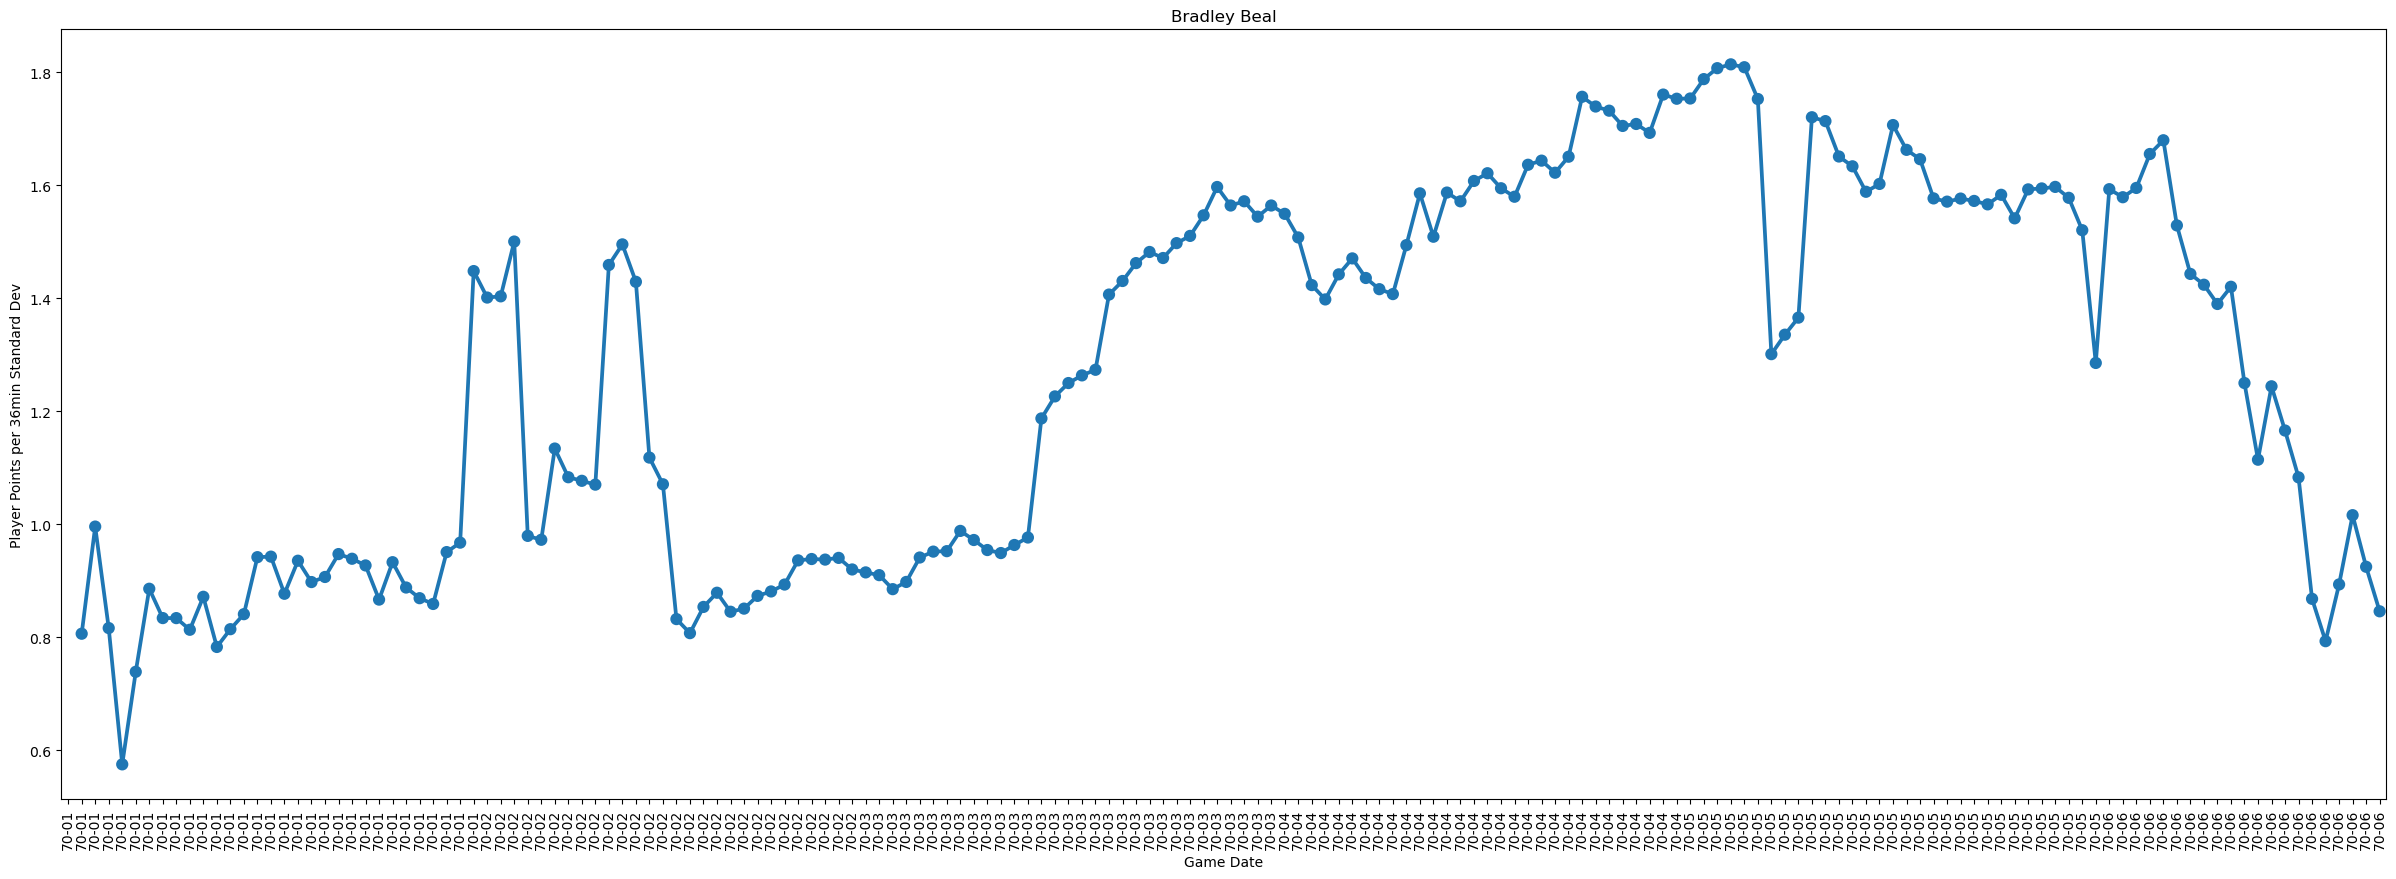

In [55]:
player_id = 37

fig = plt.figure(figsize = [30,10])
ax = sns.pointplot(data = rel_rolling_team_opp[rel_rolling_team_opp['player_id'] == player_id],
                 x = 'game_date',
                 y = 'player_pts_per36_stand',
                ci = None # Confidence Interval
                )
ax.set_title(players[players.index == player_id]['player_full_name'][player_id])
ax.set_xlabel('Game Date')
ax.set_ylabel('Player Points per 36min Standard Dev')

xaxis_date_format = mdates.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter(xaxis_date_format)

plt.xticks(rotation=90)
# fig.tight_layout()
fig.show()

In [56]:
players[players['player_last_name'] == 'Beal']

,player_team_id,player_position,player_full_name,player_first_name,player_last_name,player_height_feet,player_height_inches,player_weight_pounds
player_id,,,,,,,,
37,24,G,Bradley Beal,Bradley,Beal,6.0,5.0,207.0


In [57]:
teams[teams.index == 24]

,team_full_name,team_name,team_abbreviation,team_city,team_conference,team_division
team_id,,,,,,
24,Phoenix Suns,Suns,PHX,Phoenix,West,Pacific


In [ ]:
excel_export_path = '/'.join(['.','Data',
                              'NBA Points Stats_2021-2023.xlsx'])

rel_rolling_team_opp.to_excel(excel_export_path,
                              sheet_name = 'Points',
                              index = False)

# Extra

In [ ]:
def league_team_pts_rolling_mean(group):
    group_indexed = group.set_index('game_date')
    
    rolling_group = group_indexed.groupby(['opponent_team_id','player_position'])\
                    [['pts']]\
                    .rolling(rolling_period,
                             min_periods = 1)\
                    .mean()\
                    .shift(1)\
                    .rename(columns = {'pts':'ppg'})

    final_rolling = rolling_group.droplevel([0,1])
    
    return final_rolling

In [ ]:
team_stats_rolling_eff[(team_stats_rolling_eff['opponent_team_id'] == 1)
                       & (team_stats_rolling_eff['player_position'] == 'C')]

In [ ]:
team_stats_by_game[team_stats_by_game['team_id'] == 10]